# Классификация лего

In [165]:
import numpy as np
import matplotlib.pyplot as plt

import pickle

from tqdm.notebook import tqdm, trange

import torch as t
from torch import nn
from torch.nn import functional as f
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms

from sklearn.metrics import classification_report

In [166]:
# Импорт данных
train_data = pickle.load(open('data/lego-train.pickle', 'rb'))
test_data = pickle.load(open('data/lego-test.pickle', 'rb'))

In [167]:
# Функция для подготовки данных
def data_to_TensorDataset(data, transform_fn):
    objects = t.Tensor([img for img, _ in data]).permute(0, 3, 1, 2)
    objects = transform_fn(objects)
    targets = t.LongTensor([lbl for _, lbl in data])
    
    dataset = TensorDataset(objects, targets)
    return dataset

In [168]:
# Создаем трансформер для изображений
transform = transforms.Compose([
    transforms.Normalize(0.5, 0.5),
    transforms.RandomCrop(48, padding=4),
])

train_data = data_to_TensorDataset(train_data, transform)
test_data = data_to_TensorDataset(test_data, transform)

In [169]:
def train(model, gadget, train_loader, test_loader, criterion, optimizer,
          num_epochs, train_losses_list = None, test_losses_list = None):
    """Функция обучения нейросети"""
    if train_losses_list is None and test_losses_list is None:
        train_losses_list = []
        test_losses_list = []
    
    for _ in trange(num_epochs):
        model.train()
        
        desc = round(test_losses_list[-1], 4) if len(test_losses_list) > 0 else np.inf
        for batch in tqdm(train_loader, desc=f'Последний loss={desc}'):
            X_batch = batch[0].to(gadget)
            y_batch = batch[1].to(gadget)
            
            optimizer.zero_grad()
            
            logit = model(X_batch)
            loss = criterion(logit, y_batch)
    
            loss.backward()
            optimizer.step()
    
            train_losses_list.append(loss.item())
        
        model.eval()
        with t.no_grad():
            for batch in test_loader:
                X_batch = batch[0].to(gadget)
                y_batch = batch[1].to(gadget)
                
                loss = criterion(model(X_batch), y_batch)
                test_losses_list.append(loss.item())
        
    return train_losses_list, test_losses_list

In [458]:
class StNet(nn.Module):
    def __init__(self):
        super(StNet, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=2, stride=2)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        
        self.fc1 = nn.Linear(in_features=256, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=128)
        self.fc4 = nn.Linear(in_features=128, out_features=10)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.batch_norm_cv1 = nn.BatchNorm2d(num_features=16, eps=0.001)
        self.batch_norm_cv2 = nn.BatchNorm2d(num_features=32, eps=0.001)
        self.batch_norm_cv3 = nn.BatchNorm2d(num_features=64, eps=0.001)
        self.batch_norm_cv4 = nn.BatchNorm2d(num_features=128, eps=0.001)
        
        self.dropout = nn.Dropout(p=0.2)
        
        
    def forward(self, x):
        # Convolutional layers
        out = self.batch_norm_cv1(self.pool(f.relu(self.conv1(x))))  # BSx16x22x22
        out = self.batch_norm_cv2(f.relu(self.conv2(out)))  # BSx32x20x20
        out = self.batch_norm_cv3(f.relu(self.conv3(out)))  # BSx64x10x10
        out = self.batch_norm_cv4(self.pool(f.relu(self.conv4(out))))  # BSx128x4x4
        out = self.avg_pool(f.relu(self.conv5(out)))  # BSx128x4x4-> BSx2048
        
        out = t.flatten(out, 1)
        
        # Fully-connected layers
        out = self.dropout(f.relu(self.fc1(out)))
        out = self.dropout(f.relu(self.fc2(out)))
        out = f.relu(self.fc3(out))
        out = self.fc4(out)
        
        return out

In [497]:
# Используем по возможности CUDA
device = 'cuda' if t.cuda.is_available() else 'cpu'
my_model = StNet().to(device)

# Задаем гиперпараметры
learning_rate = 0.0003
batch_size = 16
epochs = 50

# Создаем DataLoader'ы
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_data, batch_size=batch_size, num_workers=0)

# Фиксируем функцию потерь и оптимизатор
loss_function = nn.CrossEntropyLoss()
optim = t.optim.Adam(my_model.parameters(), lr=learning_rate)

In [498]:
# Обучение модели
train_losses, test_losses = train(my_model, device, train_dataloader, test_dataloader, loss_function, optim, epochs)

  0%|          | 0/50 [00:00<?, ?it/s]

Последний loss=inf:   0%|          | 0/29 [00:00<?, ?it/s]

Последний loss=2.1111:   0%|          | 0/29 [00:00<?, ?it/s]

Последний loss=1.8416:   0%|          | 0/29 [00:00<?, ?it/s]

Последний loss=1.3011:   0%|          | 0/29 [00:00<?, ?it/s]

Последний loss=1.1227:   0%|          | 0/29 [00:00<?, ?it/s]

Последний loss=1.0445:   0%|          | 0/29 [00:00<?, ?it/s]

Последний loss=0.7564:   0%|          | 0/29 [00:00<?, ?it/s]

Последний loss=0.9649:   0%|          | 0/29 [00:00<?, ?it/s]

Последний loss=0.372:   0%|          | 0/29 [00:00<?, ?it/s]

Последний loss=0.9009:   0%|          | 0/29 [00:00<?, ?it/s]

Последний loss=0.254:   0%|          | 0/29 [00:00<?, ?it/s]

Последний loss=0.3423:   0%|          | 0/29 [00:00<?, ?it/s]

Последний loss=0.2899:   0%|          | 0/29 [00:00<?, ?it/s]

Последний loss=0.1643:   0%|          | 0/29 [00:00<?, ?it/s]

Последний loss=0.4377:   0%|          | 0/29 [00:00<?, ?it/s]

Последний loss=0.3797:   0%|          | 0/29 [00:00<?, ?it/s]

Последний loss=0.5478:   0%|          | 0/29 [00:00<?, ?it/s]

Последний loss=0.206:   0%|          | 0/29 [00:00<?, ?it/s]

Последний loss=0.1321:   0%|          | 0/29 [00:00<?, ?it/s]

Последний loss=0.1321:   0%|          | 0/29 [00:00<?, ?it/s]

Последний loss=0.4095:   0%|          | 0/29 [00:00<?, ?it/s]

Последний loss=0.1818:   0%|          | 0/29 [00:00<?, ?it/s]

Последний loss=0.1998:   0%|          | 0/29 [00:00<?, ?it/s]

Последний loss=0.1042:   0%|          | 0/29 [00:00<?, ?it/s]

Последний loss=0.0735:   0%|          | 0/29 [00:00<?, ?it/s]

Последний loss=0.0111:   0%|          | 0/29 [00:00<?, ?it/s]

Последний loss=0.0096:   0%|          | 0/29 [00:00<?, ?it/s]

Последний loss=0.0098:   0%|          | 0/29 [00:00<?, ?it/s]

Последний loss=0.0201:   0%|          | 0/29 [00:00<?, ?it/s]

Последний loss=0.0046:   0%|          | 0/29 [00:00<?, ?it/s]

Последний loss=0.0085:   0%|          | 0/29 [00:00<?, ?it/s]

Последний loss=0.007:   0%|          | 0/29 [00:00<?, ?it/s]

Последний loss=0.0037:   0%|          | 0/29 [00:00<?, ?it/s]

Последний loss=0.0042:   0%|          | 0/29 [00:00<?, ?it/s]

Последний loss=0.1085:   0%|          | 0/29 [00:00<?, ?it/s]

Последний loss=0.1198:   0%|          | 0/29 [00:00<?, ?it/s]

Последний loss=0.0427:   0%|          | 0/29 [00:00<?, ?it/s]

Последний loss=0.0026:   0%|          | 0/29 [00:00<?, ?it/s]

Последний loss=0.0576:   0%|          | 0/29 [00:00<?, ?it/s]

Последний loss=0.0161:   0%|          | 0/29 [00:00<?, ?it/s]

Последний loss=0.0443:   0%|          | 0/29 [00:00<?, ?it/s]

Последний loss=0.0028:   0%|          | 0/29 [00:00<?, ?it/s]

Последний loss=0.0946:   0%|          | 0/29 [00:00<?, ?it/s]

Последний loss=0.0015:   0%|          | 0/29 [00:00<?, ?it/s]

Последний loss=0.0036:   0%|          | 0/29 [00:00<?, ?it/s]

Последний loss=0.002:   0%|          | 0/29 [00:00<?, ?it/s]

Последний loss=0.2555:   0%|          | 0/29 [00:00<?, ?it/s]

Последний loss=0.0097:   0%|          | 0/29 [00:00<?, ?it/s]

Последний loss=0.0409:   0%|          | 0/29 [00:00<?, ?it/s]

Последний loss=0.023:   0%|          | 0/29 [00:00<?, ?it/s]

In [490]:
# Функция для усреднения values на n_part частей
def partial_mean(values: list, n_part: int) -> list:
    return [np.mean(values[i * len(values) // n_part: (i + 1) * len(values) // n_part]) for i in range(n_part)]

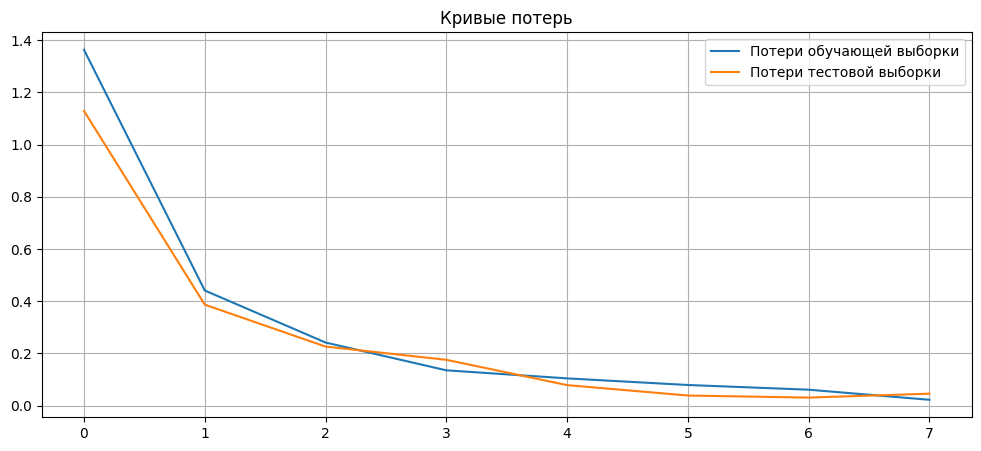

In [499]:
# Частично усредняем потери
compact_train_losses = partial_mean(train_losses, epochs // 6)
compact_test_losses = partial_mean(test_losses, epochs // 6)

plt.figure(figsize=(12, 5))

# Построим графики
plt.title('Кривые потерь')

plt.plot(compact_train_losses, label='Потери обучающей выборки')
plt.plot(compact_test_losses, label='Потери тестовой выборки')

plt.grid()
plt.legend();

In [528]:
# Заполняем реальные и предсказанные тестовые значения
y_test = []
y_pred = []

my_model.eval()
with t.no_grad():
    for Xt_batch, yt_batch in tqdm(test_dataloader):
        y_test.append(yt_batch.cpu())
        y_pred.append(t.argmax(my_model(Xt_batch.to(device)), dim=-1).cpu())

y_test = np.hstack(y_test)
y_pred = np.hstack(y_pred)

  0%|          | 0/10 [00:00<?, ?it/s]

In [501]:
# Показатели метрик
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        17
           2       1.00      1.00      1.00        12
           3       1.00      1.00      1.00        18
           4       1.00      1.00      1.00        15
           5       1.00      1.00      1.00        11
           6       1.00      1.00      1.00        16
           7       1.00      1.00      1.00        16
           8       1.00      1.00      1.00        14
           9       1.00      1.00      1.00        16

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150



Архитектура:
- 
- Свёрточных слоёв: 5
- Полносвязных слоёв: 4
- Функция активации: ReLU 
- Методы регуляризации: BatchNorm(для свёрточных слоев) и Dropout(для полносвязных)
- Количество параметров: 499306

Обучение:
-
- Learning rate = 0.0003
- Epochs count = 50

Результаты:
-
- Accuracy = 1.00
- F1-score(macro) = 1.00
